# <div style="text-align: center">  Binary Classification  </div> 


<img src="https://blogs.elespectador.com/wp-content/uploads/2017/09/logo-Universidad-Nacional.png" 
     style="float: right; margin-right: 10px;" 
     width="120"
     />

<div style="text-align: left"> 
Edison David Serrano Cárdenas. <br>
Student of Mathematics and Computer Sciences. <br>
Universidad Nacional de Colombia - Sede Bogotá <br>
</div>


# Introduction

The Machine Learning problem analized in this notebook is a suppervised learning problem, to be more specific a binary classification task.

The UCI Machine Learning Repository is the primary source of machine learning data sets mainly used by students, educators, and researchers. For this assignment we will use the following datasets

- https://archive.ics.uci.edu/ml/datasets/banknote+authentication 
- https://archive.ics.uci.edu/ml/datasets/Occupancy+Detection+

A more detailed description of these datasets can be found in the sections below.

We going to start loading  the libraries used in this document:

In [2]:
# Basic libraries.
import numpy as np
import pandas as pd
import zipfile
from pathlib import Path
import urllib.request
import numpy as np
from datetime import datetime

# Optimization libraries.
from scipy.optimize import linprog

# Data Preprocessing libraries.
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Machine Learning Models and Metrics.
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

# Metrics and GridSearch.
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_classification

# Visualization libraries.
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
import plotly.express as px
from plotly.offline import plot
from plotly.subplots import make_subplots

# Data Description and Exploratory Analysis 

## Banknote Authentication Data Set

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/d/d3/Currencies_on_White_Background.jpg/440px-Currencies_on_White_Background.jpg" 
     style="float: right; margin-right: 10px;" 
     width="300"
     />
**Abstract:** 
<!---
Data were extracted from images that were taken for the evaluation of an authentication procedure for banknotes.
--->
A set of images taken from genuine and forged banknote-like specimens is created. Features such as wavelet variance, wavelet skewness, wavelet kurtosis, and image entropy are extracted from the images.

The label which we are working are counterfeit and non-counterfeit.

The number of instances in the data set is 1372, and the number of variables is 5 (4 features, 1 label). The 55.5% of the instances are non-counterfeit records and 44.5% are counterfeit records.



**Attributes:**

1. variance of Wavelet Transformed image (continuous)
2. skewness of Wavelet Transformed image (continuous)
3. curtosis of Wavelet Transformed image (continuous)
4. entropy of image (continuous)
5. class (integer)


**Note:** To understand how Wavelet transform works, the  video [Wavelets: a mathematical microscope](https://www.youtube.com/watch?v=jnxqHcObNK4) present an interesting approach.

In [3]:
bank_note_df = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/00267/data_banknote_authentication.txt", 
                 sep = ',', 
                 header = None, 
                 names=["variance_of_Wavelet","skewness_of_Wavelet",
                        "curtosis_of_Wavelet","entropy",
                        "class"],
                 thousands = ',')
variables_Banknote=["variance_of_Wavelet","skewness_of_Wavelet", "curtosis_of_Wavelet","entropy"]

In [4]:
print("Dimensionality of the Dataframe:",bank_note_df.shape)

Dimensionality of the Dataframe: (1372, 5)


In [5]:
print("Class Percentage:")
bank_note_df["class"].value_counts(normalize=True)

Class Percentage:


0    0.555394
1    0.444606
Name: class, dtype: float64

**Looking for Correlations**

It is important visualize the variables to understand their behaviour and how these are related with the others. We can deal with this with the scatter and correlation matrices.

**Scatter Matrix:**  The graph below tell us that there is a possible clustering by groups, there are not notorious outliers in the dataset and there is a pair-wise relationships between the variables mainly described by a curve.

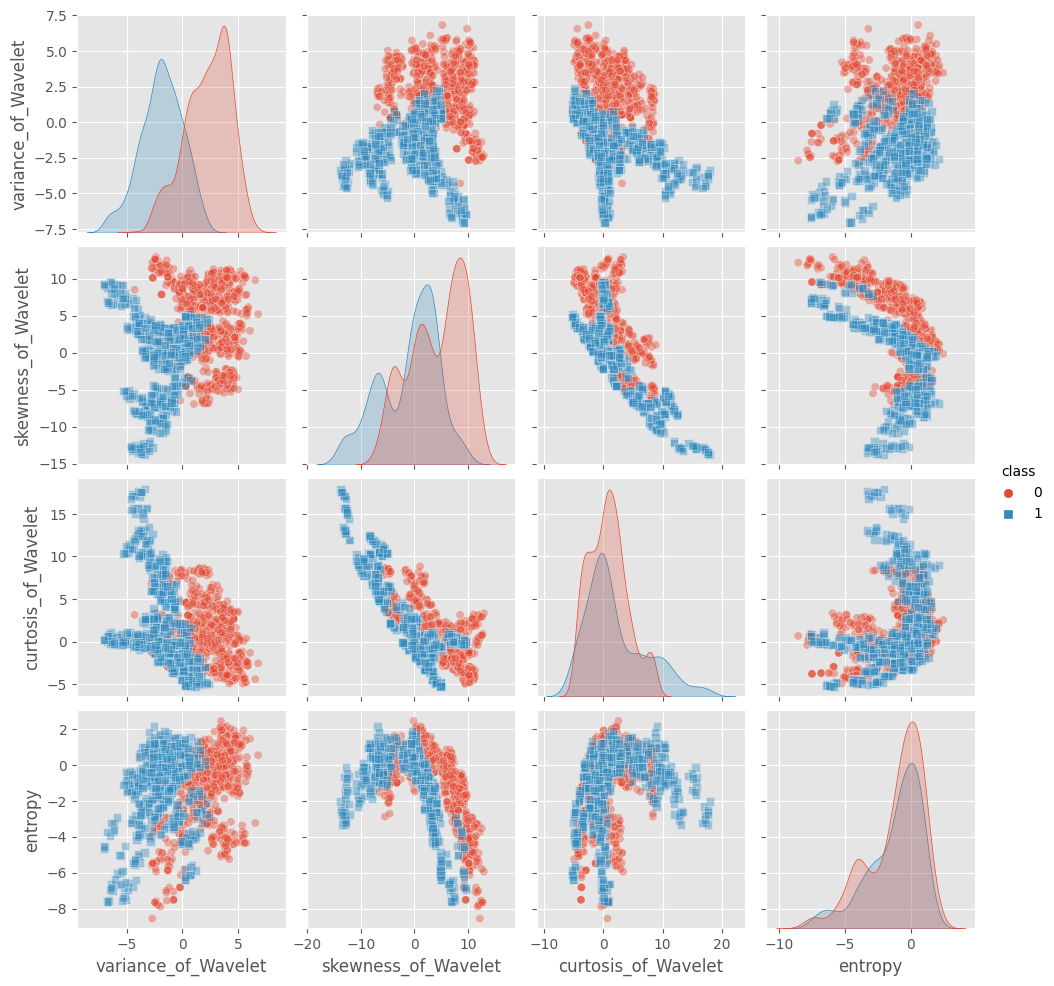

In [6]:
sns.pairplot(bank_note_df, hue="class",plot_kws={'alpha':0.4},markers=["o", "s"])
plt.show()

**Correlation Matrix:**

It is important took a look at how much each attribute correlates with the label. In the next cells say us that the least correcolated variable is the *entropy*, and the most correcolate variable is *variance_of_Wavelet* with a negative coefficient of 0.7248.

In [7]:
bank_note_df.corr()["class"].sort_values(ascending=False)

class                  1.000000
curtosis_of_Wavelet    0.155883
entropy               -0.023424
skewness_of_Wavelet   -0.444688
variance_of_Wavelet   -0.724843
Name: class, dtype: float64

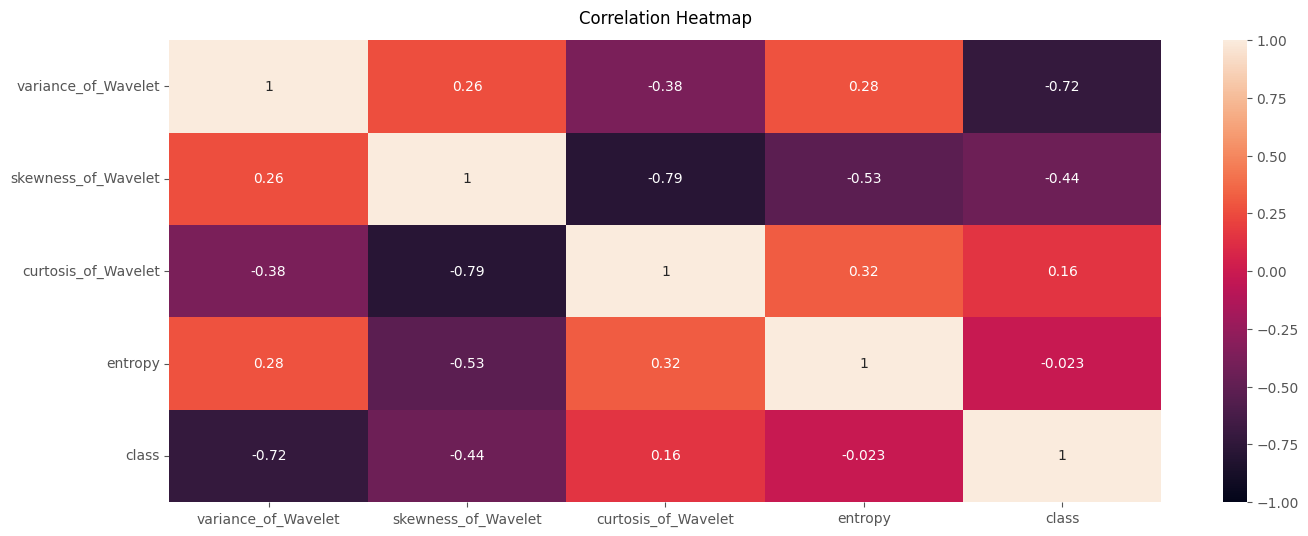

In [8]:
# Increase the size of the heatmap.
plt.figure(figsize=(16, 6))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(bank_note_df.corr(), vmin=-1, vmax=1, annot=True)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);


*NOTA:* El diseño experimental conlleva a la generalización. En el segundo se ve afectado, por los intervalos de tiempo fijos en una habitación fija.  

## Occupancy Detection Data Set

<img src="https://www.trueoccupancy.com/hubfs/Occupancy%20Sensors%20-%20Room%20Sensors%20-%20600x315.png" 
     style="float: right; margin-right: 10px;" 
     width="300"
     />
**Abstract:** 

Experimental data used for binary classification (room occupancy) from Temperature,Humidity,Light and CO2. Ground-truth occupancy was obtained from time stamped pictures that were taken every minute.

The number of instances in the data set is 20560, and the number of variables is 7.

**Attribute Information:**

- date time year-month-day hour:minute:second
- Temperature, in Celsius
- Relative Humidity, %
- Light, in Lux
- CO2, in ppm
- Humidity Ratio, Derived quantity from temperature and relative humidity, in kgwater-vapor/kg-air
- Occupancy 0 or 1; 0 for not occupied, 1 for occupied status


In [9]:
dateparse = lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S')

def load_occupacy_data():
    tarball_path = Path("datasets/occupancy_data.zip")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00357/occupancy_data.zip"
        urllib.request.urlretrieve(url, tarball_path)
        with zipfile.ZipFile(tarball_path) as occupancy_tarball:
           # open the csv file in the dataset
           occupancy_tarball.extractall(path="datasets")
    list_df =[pd.read_csv(Path("datasets/datatraining.txt"),parse_dates=['date'],date_parser=dateparse),
              pd.read_csv(Path("datasets/datatest.txt"),parse_dates=['date'],date_parser=dateparse),
              pd.read_csv(Path("datasets/datatest2.txt"),parse_dates=['date'],date_parser=dateparse),]
    return list_df

In [41]:
train_, test1_, test2_= load_occupacy_data()

In [50]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer

In [49]:
def convert_date(df):
    df["date"] = df["date"].apply(lambda time: time.year+time.month/12+ time.day/365 + time.hour/8760+time.minute/525600)
    return df

In [58]:
# Define a pipeline to clean your data
cleaning_pipeline = Pipeline([
    # Convert the 'date' column into days
    ('date_to_days', FunctionTransformer(convert_date)),
    #  Drop rows with missing values
    ('drop', 
    # Standardize the features to have mean=0 and variance=1
    ('scaler', StandardScaler())
])

# Define a column transformer to select the columns to clean
column_transformer = ColumnTransformer([
    # Clean numerical columns
    ('cleaning', cleaning_pipeline, ['Temperature', 'Humidity', 'Light', 'CO2', 'HumidityRatio','date']),
    
    # Keep categorical columns as is    # Convert the 'date' column into days
    
    #('no_cleaning', 'passthrough', [ ])
])

# Apply the pipeline to your data
X_clean = column_transformer.fit_transform(train_.drop(columns=['Occupancy']))

InvalidParameterError: The 'strategy' parameter of SimpleImputer must be a str among {'mean', 'median', 'most_frequent', 'constant'}. Got 'drop' instead.

In [ ]:
Sure, if drop is not working for your pipeline and you would like to remove rows with missing values instead, you can replace the DropColumns transformer with a FunctionTransformer that applies a function to drop rows with missing values.

Here's an example of how you can modify the pipeline to drop rows with missing values instead of columns:

python
Copy code
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import FunctionTransformer
import pandas as pd
import numpy as np

def drop_rows_with_missing_values(X):
    return X.dropna()

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, ['age', 'fare']),
        ('cat', 'passthrough', ['sex', 'embarked']),
        ('date', 'passthrough', ['date'])
    ])

pipeline = make_pipeline(
    preprocessor,
    FunctionTransformer(drop_rows_with_missing_values),
    SVC(kernel='rbf', C=1, gamma='scale'))

# Load data
data = pd.read_csv('data.csv')

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    data[['age', 'fare', 'sex', 'embarked', 'date']], 
    data['survived'], 
    test_size=0.2, 
    random_state=0)

# Fit pipeline on training data
pipeline.fit(X_train, y_train)

# Predict test data
y_pred = pipeline.predict(X_test)

# Calculate F1 score
f1 = f1_score(y_test, y_pred)

# Calculate cross-validation score
cv_scores = cross_val_score(pipeline, data[['age', 'fare', 'sex', 'embarked', 'date']], data['survived'], cv=5, scoring='f1')

array([[ 2.51847007,  0.27852622,  1.57376283,  0.36494808,  1.09175697,
        -1.73170569],
       [ 2.48896731,  0.27771261,  1.59173515,  0.34188106,  1.08055497,
        -1.73170569],
       [ 2.48896731,  0.27364453,  1.57376283,  0.34029023,  1.07588816,
        -1.73085488],
       ...,
       [ 0.47294534,  1.87375407,  1.60970748,  0.61073113,  2.03352707,
         1.73069423],
       [ 0.47294534,  1.90358662,  1.60970748,  0.68019732,  2.063811  ,
         1.73154505],
       [ 0.47294534,  1.89273842,  1.68159679,  0.68231843,  2.05279837,
         1.73197046]])

In [10]:
train_ocupp, test1_ocupp, test2_ocupp= load_occupacy_data()

Data imbalance is a typical problem for real world datasets. Our training dataset have this quality, because, the labels 0 and 1 contains the 78.8% and 21.2% of the data, respectly.

In [11]:
print("Train Dimensionality:")
print("Total:",train_ocupp.shape,"\nLabel 0:",
      train_ocupp[train_ocupp["Occupancy"]==0].shape,"\nLabel 1:", train_ocupp[train_ocupp["Occupancy"]==1].shape)

print("\nTest1 Dimensionality:")
print("Total:",test1_ocupp.shape,"\nLabel 0:",
      test1_ocupp[test1_ocupp["Occupancy"]==0].shape,"\nLabel 1:", test1_ocupp[test1_ocupp["Occupancy"]==1].shape)

print("\nTest2 Dimensionality:")
print("Total:",test2_ocupp.shape,"\nLabel 0:",
      test2_ocupp[test2_ocupp["Occupancy"]==0].shape,"\nLabel 1:", test2_ocupp[test2_ocupp["Occupancy"]==1].shape)

Train Dimensionality:
Total: (8143, 7) 
Label 0: (6414, 7) 
Label 1: (1729, 7)

Test1 Dimensionality:
Total: (2665, 7) 
Label 0: (1693, 7) 
Label 1: (972, 7)

Test2 Dimensionality:
Total: (9752, 7) 
Label 0: (7703, 7) 
Label 1: (2049, 7)


The variable date is not a numeric variable. We going to analyse their behaviour to propose a transformation of this variable to a numeric variable.

In [12]:
figures = [ px.line(train_ocupp, x='date', y="Occupancy",
                 width=800, height=400),
            px.line(test1_ocupp, x='date', y="Occupancy",
                 width=800, height=400),
            px.line(test2_ocupp, x='date', y="Occupancy",
                         width=800, height=400) ]

fig = make_subplots(rows=2, cols=2,
                    specs=[[{"colspan": 2}, None],[{}, {}]],
                    subplot_titles=("Train Date","Test1 Date", "Test2 Date"))


fig.append_trace(figures[0]["data"][0], row=1, col=1)
fig.append_trace(figures[1]["data"][0], row=2, col=1)
fig.append_trace(figures[2]["data"][0], row=2, col=2)

fig.show()
 

The previous graphs tell us that it is important the day, hour and minutes to describe the two categories. The day has relevant information if is o not a holiday, is normal think that in holidays there is low occupacy, the hour and minutes help us to describe the begining and end of the journey.

**Date Transformation:** We going to convert the date to years unit. For example: 2015-02-04 17:51:00 it is converted to 2015.179663. The month could be irrelevant by the train data time period, but it is include in the analysis.

In [13]:
train_ocupp['date_numeric'] = train_ocupp['date'].apply(lambda time: time.year+time.month/12+ time.day/365 + time.hour/8760+time.minute/525600)
test1_ocupp['date_numeric'] = test1_ocupp['date'].apply(lambda time: time.year+time.month/12+ time.day/365 + time.hour/8760+time.minute/525600)
test2_ocupp['date_numeric'] = test2_ocupp['date'].apply(lambda time: time.year+time.month/12+ time.day/365 + time.hour/8760+time.minute/525600)

In [14]:
variables_occupancy = ['date_numeric', 'Temperature', 'Humidity', 'Light', 
              'CO2', 'HumidityRatio']

**Histograms:**

The behaviour of the pairwaise plots do not allows analyse the variables. The approach in this case is using histograms. How we can see in the bellow cell that variable *Light* divide data into two categories clearly.

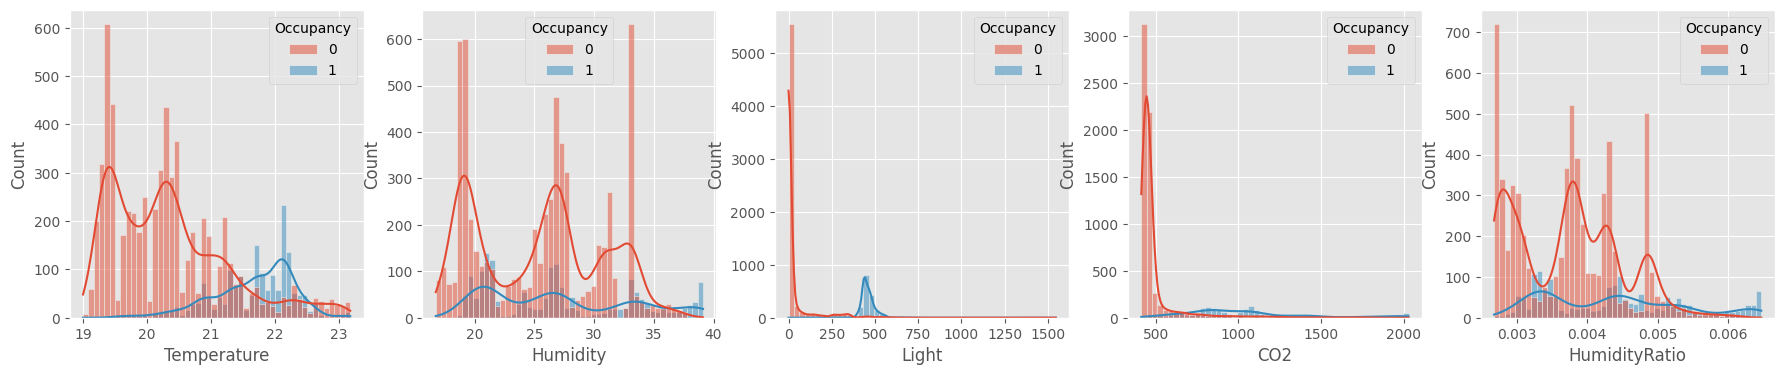

In [15]:
fig,axs = plt.subplots(1,5, figsize = (22,4))
for i in range(1,6):
    sns.histplot(data=train_ocupp,bins=50, x=variables_occupancy[i], kde=True, ax=axs[i-1],hue="Occupancy")

**Correlation Matrix:**

The features are highly and moderately correlated with the objetive variable. It says that features could describe in a efficient way the objetive variable.

In [16]:
train_ocupp[variables_occupancy+['Occupancy']].corr().corr()['Occupancy'].sort_values(ascending=False)

Occupancy        1.000000
Light            0.981397
Temperature      0.802338
CO2              0.770067
HumidityRatio   -0.558999
Humidity        -0.699947
date_numeric    -0.828121
Name: Occupancy, dtype: float64

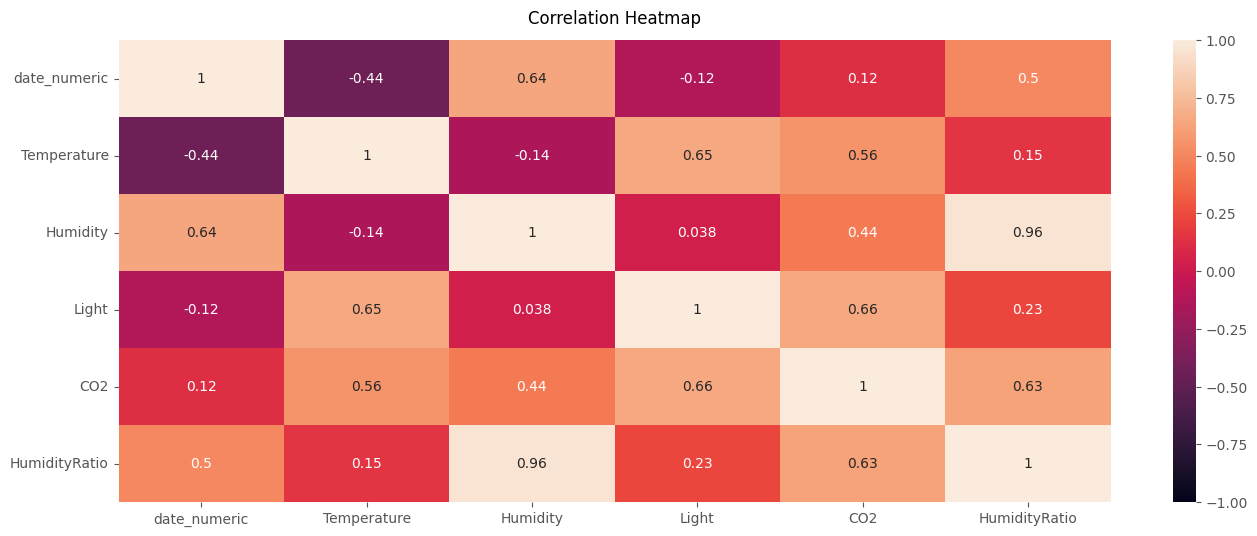

In [17]:
# Increase the size of the heatmap.
plt.figure(figsize=(16, 6))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(train_ocupp[variables_occupancy].corr(), vmin=-1, vmax=1, annot=True)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

# Linear Separability

## Linear Separability with Linear Programming

**Definition:** Let $A=\{a_1,\dots,a_n\}$ and $B=\{b_1,\dots,b_m\}$ be finite sets. Then, these sets are linearly separable if exist $w$ and $b$ such that $a_i\cdot w +b\geq 0$ and $b_j\cdot w +b\leq 0$. 

The previous definition could be written as a linear programming (LP) Problem as follows

$$
\begin{align*}
\min_{x}& &0\\
\text{subject to:}& & Ax\leq b
\end{align*}
$$

where $A=\begin{bmatrix}
-P_A & \vec{1} \\
P_B & -\vec{1} 
\end{bmatrix}$, $P_A=\begin{bmatrix}a_1 & \cdots & a_n \end{bmatrix}^{T}$, $P_B=\begin{bmatrix}b_1 & \cdots & b_m \end{bmatrix}^{T}$ and 
$b=\begin{bmatrix}1 & \cdots &1 \end{bmatrix}$.

In [18]:
def lp_linearly_sep(points_1,points_2):
    
    A1 =  np.concatenate((-points_1,np.ones((len(points_1),1))),axis=1)
    A2 = np.concatenate((points_2,- np.ones((len(points_2),1))),axis =1)
    
    A = np.concatenate((A1,A2))
    b=np.full(len(A),-1)
    c=np.zeros(len(A1[0]))
    
    lp = linprog(c, A_ub=A, b_ub=b)
    
    return lp.success

**Testing Function:** 

The sets are Linearly-Separable: True


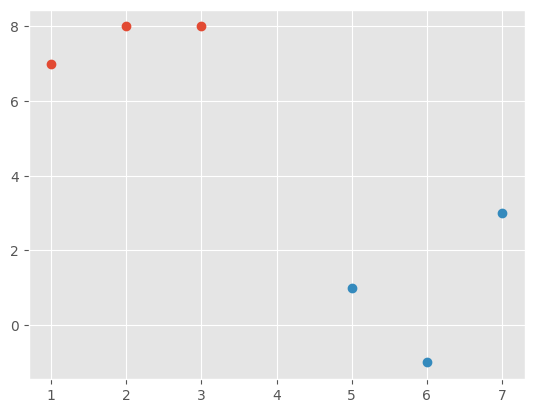

The sets are Linearly-Separable: False


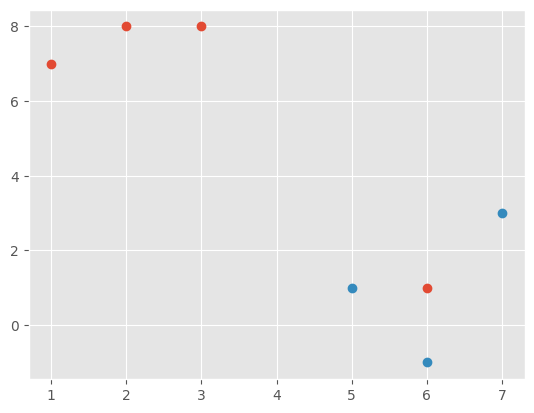

In [19]:
points_1 = np.array([[1,7],[2,8],[3,8]])
points_2 = np.array([[5,1],[6,-1],[7,3]])
points_3 = np.array([[1,7],[2,8],[3,8],[6,1]])
print("The sets are Linearly-Separable:",lp_linearly_sep(points_1,points_2))
plt.plot(points_1[:,0],points_1[:,1],'o')
plt.plot(points_2[:,0],points_2[:,1],'o')
plt.show()
print("The sets are Linearly-Separable:",lp_linearly_sep(points_2,points_3))
plt.plot(points_3[:,0],points_3[:,1],'o')
plt.plot(points_2[:,0],points_2[:,1],'o')
plt.show()


**Banknote Authentication Data Set:**

In [20]:
print("The sets are Linearly-Separable:",
      lp_linearly_sep(bank_note_df[bank_note_df["class"] ==0].drop("class",axis=1),
                      bank_note_df[bank_note_df["class"] ==1].drop("class",axis=1)))

The sets are Linearly-Separable: False


**Occupancy Detection Data Set:**

In [21]:
train_ocupp_nodate = train_ocupp.drop("date",axis=1)
train_label0_occupancy = train_ocupp_nodate.loc[train_ocupp_nodate["Occupancy"]==0]
train_label1_occupancy = train_ocupp_nodate.loc[train_ocupp_nodate["Occupancy"]==1]

In [22]:
print("The sets are Linearly-Separable:",
      lp_linearly_sep(train_label0_occupancy.drop("Occupancy",axis=1) ,
                      train_label1_occupancy.drop("Occupancy",axis=1)))

The sets are Linearly-Separable: False


## Convex Hull to analyze Linearly-separable

Unfortunely, this approach does not have succesful performance. The Warning signs indicate it. This method is inefficient because it solve many LP problems.

**Proposition:** Two sets are linearly separable if and only if their convex hulls don’t
intersect, [AM 221: Advanced Optimization - Yaron Singer - 3.1 Separability](https://people.seas.harvard.edu/~yaron/AM221-S16/lecture_notes/AM221_lecture13.pdf).

Keeping this in mind, to determine if a point $x$ belong to the convex hull of the points $\{p_1,p_2,\cdots,p_k\}$, it's enough determine if exist a convex combination of the points equal to the point $x$, in other words, there is a non-negative vector $\lambda\in\mathbb{R}^k$, such that,

$$\sum_{i} p_{i}^T\lambda_i=x \text{    and    } \sum_j \lambda_j=1$$

The function *in_hull* use the previous idea to determine if a point $x$ belong to the convex hull of $\{p_i\}_{1\leq i\leq k}$, analysing if a linear programming problem is feasible.

In [23]:
def in_hull(points, x):
    n_points = len(points)
    n_dim = len(x)
    c = np.zeros(n_points)
    A = np.r_[points.T,np.ones((1,n_points))]
    b = np.r_[x, np.ones(1)]
    lp = linprog(c, A_eq=A, b_eq=b)
    return lp.success

The two sets of each class are finite, so to determine if the convex hull does not intersect it is enough show that for any point of a class do not belong to the convex hull of the other class.

In [24]:
def conv_hull_linearly_sep(df_0,df_1):
    r=0
    for i in range(df_1.shape[0]): #
        if in_hull(df_0.to_numpy(), df_1.iloc[i]):
            r=r+1
    for i in range(df_0.shape[0]):
        if in_hull(df_1.to_numpy(), df_0.iloc[i]):
            r=r+1
    print("Error Porcentage:",round(r/(df_0.shape[0]+df_1.shape[0])*100,4),"%")
    return r==0

**Testing Function:**

In [25]:
print("The sets are Linearly-Separable:",
      conv_hull_linearly_sep(pd.DataFrame(points_1),pd.DataFrame(points_2)))

Error Porcentage: 0.0 %
The sets are Linearly-Separable: True


In [26]:
print("The sets are Linearly-Separable:",
      conv_hull_linearly_sep(pd.DataFrame(points_3),pd.DataFrame(points_2)))

Error Porcentage: 14.2857 %
The sets are Linearly-Separable: False


**Banknote Authentication Data Set:**

In [27]:
print("The sets are Linearly-Separable:",
      conv_hull_linearly_sep(bank_note_df[bank_note_df["class"] ==0].drop("class",axis=1),
                             bank_note_df[bank_note_df["class"] ==1].drop("class",axis=1)))

Error Porcentage: 0.0 %
The sets are Linearly-Separable: True


**Occupancy Detection Data Set:**

In [28]:
print("The sets are Linearly-Separable:",
      conv_hull_linearly_sep(train_label0_occupancy.drop("Occupancy",axis=1) ,
                             train_label1_occupancy.drop("Occupancy",axis=1)))

Error Porcentage: 2.9473 %
The sets are Linearly-Separable: False


> **Warning:** LinAlgWarning: Ill-conditioned matrix ...: result may not be accurate. <br>
>
>Error Porcentage: 0.4175 %<br>
>The sets are Linearly-Separable: False<br>
>
>**Note:** The warning message dissapear and the error is now 2.95%. 

# Data Processing

## Data Splitting

To ensure that this notebook's outputs remain the same every time we run it, we need to set the random seed:

In [29]:
np.random.seed(42)

Banknote Authentication Data Set

In [30]:
# In the first step we will split the data in training and remaining dataset
X_train_banknote, X_rem, y_train_banknote, y_rem = train_test_split(bank_note_df[variables_Banknote],bank_note_df["class"], train_size=0.8)

# Now since we want the valid and test size to be equal (10% each of overall data). 
# we have to define valid_size=0.5 (that is 50% of remaining data)
test_size = 0.5
X_valid_banknote, X_test_banknote, y_valid_banknote, y_test_banknote = train_test_split(X_rem,y_rem, test_size=0.5)

Occupancy Detection Data Set is already splitted in three sets.

## Feature Scaling

In [31]:
#Banknote Authentication Data Set:
scaler_banknote = StandardScaler()
df_banknote_transformed = scaler_banknote.fit_transform(X_train_banknote)
df_banknote_transformed_test = scaler_banknote.transform(X_test_banknote)

#Occupancy Detection Data Set:
scaler_occupacy = StandardScaler()
df_occupancy_transformed = scaler_occupacy.fit_transform(train_ocupp_nodate)

# Hyper-parameter Adjustment

We aim to determine the appropriate hyperparameters using the training dataset. To do this, we need to define a function beforehand that allows us to compare the performance of each model with different parameters.

## Performance Metric Definition

In addition, we define an auxiliary function that we will call a metric that allows us to evaluate the performance of our algorithms and thus determine the hyperparameters. This metric is the F1 score, which corresponds to the harmonic mean between recall and precision.

This metric is used because it is supposed that the bank is worried about the comfortability of their clients and wants to mantain a high recall and accuaracy. 

## Hyperparameter Tunning

### Logistic Regression

In [32]:
# Define Logistic Regression model
model_logistic_reg = LogisticRegression()

# Define hyperparameters for tuning
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000,10000], 
              'penalty':['l2'] } #['l1', 'l2', 'elasticnet', 'none']}

# Define F1 score as the metric for evaluation
f1 = make_scorer(f1_score)

# Tune hyperparameters using GridSearchCV
log_grid_search = GridSearchCV(model_logistic_reg, param_grid, cv=5, scoring=f1)
log_grid_search.fit(df_banknote_transformed, y_train_banknote)

# Print best hyperparameters and F1 score
print("Best Hyperparameters: ", log_grid_search.best_params_)
print("Best F1 Score: ", log_grid_search.best_score_)

Best Hyperparameters:  {'C': 1000, 'penalty': 'l2'}
Best F1 Score:  0.9916771803099673


### Support Vector Machine (SVM)

In [33]:
# Define the SVM classifier
model_svm = SVC()

# Define the parameter grid
param_grid = {'C': [0.01, 0.1, 1, 10, 100], 
              'gamma': [0.1, 1, 10, 100]}

# Define the GridSearchCV object
svm_grid_search = GridSearchCV(model_svm, param_grid, cv=5, scoring=f1)

# Fit the GridSearchCV object to the data
svm_grid_search.fit(df_banknote_transformed, y_train_banknote)

# Print the best hyperparameters
print("Best hyperparameters: ", svm_grid_search.best_params_)
print("Best F1 Score: ", svm_grid_search.best_score_)

Best hyperparameters:  {'C': 1, 'gamma': 10}
Best F1 Score:  1.0


### K-Nearest Neighbor(KNN)

In [34]:
# Define the KNN classifier
knn = KNeighborsClassifier()

# Define the parameter grid
param_grid = {'n_neighbors': [3, 5, 7, 9], 
              'weights': ['uniform', 'distance']}

# Define the GridSearchCV object
knn_grid_search = GridSearchCV(knn, param_grid, cv=5, scoring=f1)

# Fit the GridSearchCV object to the data
knn_grid_search.fit(df_banknote_transformed, y_train_banknote)

# Print the best hyperparameters
print("Best hyperparameters: ", knn_grid_search.best_params_)
print("Best F1 Score: ", knn_grid_search.best_score_)

Best hyperparameters:  {'n_neighbors': 3, 'weights': 'uniform'}
Best F1 Score:  0.9979380895443072


### Decision Tree Classifier

In [35]:
# Define the Decision Tree classifier
dtc = DecisionTreeClassifier()

# Define the parameter grid
param_grid = {'max_depth': [5, 10, 15, 20], 
              'min_samples_split': [2, 5, 10, 15, 20]}

# Define the GridSearchCV object
dtc_grid_search = GridSearchCV(dtc, param_grid, cv=5, scoring=f1)

# Fit the GridSearchCV object to the data
dtc_grid_search.fit(df_banknote_transformed, y_train_banknote)
# Print the best hyperparameterssvm
print("Best hyperparameters: ", dtc_grid_search.best_params_)
print("Best F1 Score: ", dtc_grid_search.best_score_)

Best hyperparameters:  {'max_depth': 15, 'min_samples_split': 2}
Best F1 Score:  0.9813758674999861


# Model Evaluation

Once the parameters we will use have been defined, we proceed to predict the test data. However, since we are also interested in determining which model fits best beyond this, we will additionally implement a process called cross-validation. This is a technique used to evaluate the results of a statistical analysis and ensure that they are independent of the partition between training data and test data. This allows us to compare different methods to choose the best one.

## Model Evaluation with testing data 

### Logistic Regression

### Support Vector Machine (SVM)

In [39]:
# Define your SVM model
model = SVC(kernel='linear', C=1, gamma=10)

# Define the number of folds for cross-validation
num_folds = 5

# Perform cross-validation and store the scores
scores = cross_val_score(model, df_banknote_transformed, y_train_banknote, cv=num_folds, scoring=f1)

# Print the accuracy for each fold and the mean accuracy across all folds
print("Accuracy for each fold:", scores)
print("Mean accuracy:", round(np.mean(scores),5))
print("Mean accuracy:", round(np.std(scores),5))

Accuracy for each fold: [0.99487179 0.97979798 0.97461929 0.97938144 0.98979592]
Mean accuracy: 0.98369
Mean accuracy: 0.00746


In [40]:
model.fit(df_banknote_transformed, y_train_banknote)

predicted_svm = model.predict(df_banknote_transformed)
predicted_svm_test = model.predict(df_banknote_transformed_test)

accuracy = accuracy_score(y_train_banknote, predicted_svm).round(2)
accuracy_test = accuracy_score(y_test_banknote, predicted_svm_test).round(2)

conf_matrix = confusion_matrix(y_train_banknote, predicted_svm)
conf_matrix_test = confusion_matrix(y_test_banknote, predicted_svm_test)

print("Training Score:")
print("Accuracy: ", accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("\nTest Score:").corr()
print("Accuracy: ", accuracy_test)
print("Confusion Matrix:\n", conf_matrix_test)

Training Score:
Accuracy:  0.99
Confusion Matrix:
 [[601  13]
 [  0 483]]

Test Score:


AttributeError: 'NoneType' object has no attribute 'corr'

### K-Nearest Neighbor(KNN)

### Decision Tree Classifier

## Model Evaluation of the best model with validation data 

# Conclusions

Presentamos una tabla con un resumen de los resultados vistos anteriormente:

Realizando la validación con el mejor modelo obtuvimos que ...

Occupancy Detection Data Set <br>
Banknote Authentication Data Set

# References

[1] [Mathematics of Machine Learning (2023-01)](https://sites.google.com/site/fagomezj/matem%C3%A1ticas-del-aprendizaje-de-m%C3%A1quinas-2023?authuser=0), Francisco Gomez Website. <br>
[2] [Support Vector Machine Optimization in Python part 2](https://pythonprogramming.net/svm-optimization-python-2-machine-learning-tutorial/?completed=/svm-optimization-python-machine-learning-tutorial/), pythonprogramming. <br>
[3] [Banknote authentication data set](https://archive.ics.uci.edu/ml/datasets/banknote+authentication#), UCI Machine Learning Repository. <br>
[4] [Detect forged banknotes using Artificial Intelligence](https://www.neuraldesigner.com/learning/examples/banknote-authentication), Neuraldesigner.<br>
[5] Elizondo, D., "The linear separability problem: some testing methods," in Neural Networks, IEEE Transactions on , vol.17, no.2, pp.330-344, March 2006 doi: 10.1109/TNN.2005.860871

# To do List:

You should:

- [x] Specify which Machine Learning problem are you solving.

- [x] Provide a short summary of the features and the labels you are working on.

- [ ] Banknote Authentication Data Set
	- [x]  Summary
    - [x]  Alinearly separable 
    - [ ]  datasets randomly chosen
    - [ ]  guarantee generalization
- [ ] Occupancy Detection Data Set
	- [x]  Summary
    - [x]  Alinearly separable 
    - [ ]  datasets randomly chosen
    - [ ]  guarantee generalization

- [ ] Please answer the following questions: 
		- [ ] Are these datasets linearly separable?
        		- Convex hull each label set  are disjoint.
        - [ ] Are these datasets randomly chosen.
        		- Ver los histogramas.
                - Ver comportamiento de cada una de las muestras.
                - test: https://predictivehacks.com/how-to-test-for-randomness/,  
                        https://stats.stackexchange.com/questions/256417/single-index-to-measure-the-randomness-of-multivariate-distributions-or-data
        - [ ] The sample size is enough to guarantee generalization.


- [ ] Provide an explanation how and why the code is working. You can add comments and/or formal explanations into the notebook.

- [x] Show some examples to illustrate that the method is working properly.

- [ ] Provide quantitative evidence for generalization using the provided dataset.

	- Dividir los datos, training and testing sets. 80-20.
    - Se ajustan los parametros del modelo con train.
    - Se evalua el rendimiento.

**Class Creation:**

In [ ]:
class Support_Vector_Machine:
    def __init__(self, visualization=True):
        self.visualization = visualization
        # Colores de las clases asociadas 
        self.colors = {1:'r',-1:'b'}
        if self.visualization:
            self.fig = plt.figure()
            self.ax = self.fig.add_subplot(1,1,1)
    # train
    def fit(self, data):
        self.data = data
        # { ||w||: [w,b] }
        # Diccionario de los pesos óptimos
        opt_dict = {} 

        transforms = [[1,1],
                      [-1,1],
                      [-1,-1],
                      [1,-1]]
		
        # Reconstrucción del dataset
        all_data = [] # Vector de caracteristicas
        for yi in self.data:
            for featureset in self.data[yi]:
                for feature in featureset:
                    all_data.append(feature)

        self.max_feature_value = max(all_data)
        self.min_feature_value = min(all_data)
        all_data = None

        # support vectors yi(xi.w+b) = 1
        
        step_sizes = [self.max_feature_value * 0.1,
                      self.max_feature_value * 0.01,
                      # point of expense:
                      self.max_feature_value * 0.001,]

        
        
        # extremely expensive
        b_range_multiple = 5
        # we dont need to take as small of steps
        # with b as we do w
        b_multiple = 5
        latest_optimum = self.max_feature_value*10

        for step in step_sizes:
            w = np.array([latest_optimum,latest_optimum])
            # we can do this because convex
            optimized = False
            while not optimized:
                for b in np.arange(-1*(self.max_feature_value*b_range_multiple),
                                   self.max_feature_value*b_range_multiple,
                                   step*b_multiple):
                    for transformation in transforms:
                        w_t = w*transformation
                        found_option = True
                        # weakest link in the SVM fundamentally
                        # SMO attempts to fix this a bit
                        # yi(xi.w+b) >= 1
                        # 
                        # #### add a break here later..
                        for i in self.data:
                            for xi in self.data[i]:
                                yi=i
                                # Verifiy constraints
                                if not yi*(np.dot(w_t,xi)+b) >= 1:
                                    found_option = False
                                    
                        if found_option:
                            # Computes norm
                            opt_dict[np.linalg.norm(w_t)] = [w_t,b]

                if w[0] < 0:
                    optimized = True
                    print('Optimized a step.')
                else:
                    w = w - step

            norms = sorted([n for n in opt_dict])
            #||w|| : [w,b]
            opt_choice = opt_dict[norms[0]]
            self.w = opt_choice[0]
            self.b = opt_choice[1]
            latest_optimum = opt_choice[0][0]+step*2
            
    # Ingresa el dato a predecir. Retorna la etiqueta asociada
    def predict(self,features):
        # sign( x.w+b )
        # Clasifica a partir del signo de la desigualdad con los pesos ya calculados.
        classification = np.sign(np.dot(np.array(features),self.w)+self.b)
        return classification
    
data_dict = {-1:np.array([[1,7],
                          [2,8],
                          [3,8],]),
             
             1:np.array([[5,1],
                         [6,-1],
                         [7,3],])}

svm1 = Support_Vector_Machine(visualization=False)
svm1.fit(data_dict)

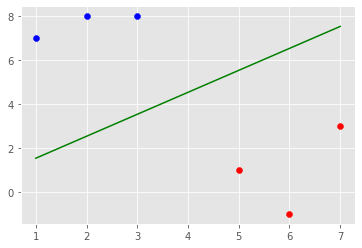

In [ ]:
# Create 
x =np.linspace(1,7,3)
w = svm1.w
b = svm1.b
y = (-b-w[0]*x)/w[1]

plt.scatter(data_dict[-1][:,0],data_dict[-1][:,1],c="b")
plt.scatter(data_dict[1][:,0],data_dict[1][:,1],c="r")
plt.plot(x,y,c="green")
#plt.plot()
plt.show()

#### K-means for linear-separability (No sirve, pero el código de la matriz de confusión y la precisión sirve)

The Kmeans algorithms briefly consist in find the centroids which minimize the variance of each class with their associate centroid and divide groups using the Voronoi diagram. In our case, how is a binary classification task, then if data are linearly separable we should obtain a accurary nearly to 1 using this method  [5].

In [ ]:
X=df.drop(["class"],axis=1).values
kmeans = KMeans(n_clusters=2).fit(X)

centroids = kmeans.cluster_centers_
labels = kmeans.labels_
accuracy = accuracy_score(df["class"], labels).round(2)
conf_matrix = confusion_matrix(df["class"], labels)

print("Centroids:\n", centroids)

In [ ]:
print("Accuracy: ", accuracy)
print("Confusion Matrix:\n", conf_matrix)

In [ ]:
ax = sns.heatmap(conf_matrix, annot=True, fmt='d', )

# set x-axis label and ticks. 
ax.set_xlabel("Predicted Diagnosis", fontsize=14, labelpad=20)
ax.xaxis.set_ticklabels(['Negative', 'Positive'])

# set y-axis label and ticks
ax.set_ylabel("Actual Diagnosis", fontsize=14, labelpad=20)
ax.yaxis.set_ticklabels(['Negative', 'Positive'])

# set plot title
ax.set_title("Confusion Matrix for the Diabetes Detection Model", fontsize=14, pad=20)

plt.show()

The previous results indicated us that the two classes are non linearly-separable data.